<a href="https://colab.research.google.com/github/mzvirikuzhe/Miracle-Zvirikikuzhe-COS802-Project/blob/main/u25606426_Miracle_Zvirikuzhe_Final_Project_Cos80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

AFRICAN LANGUAGES SEMANTIC RELATEDNESS WITH WANDB INTEGRATION
Complete pipeline with Weights & Biases tracking for performance monitoring
"""


RESEARCH QUESTIONS:
1. Which transfer learning approaches best improve semantic relatedness
   determination in African languages?
2. How do baseline multilingual models compare to fine-tuned models
   for Hausa, Kinyarwanda, and Amharic?

METHODOLOGY:
- Baseline: LaBSE and Multilingual MPNet
- Transfer Learning: Fine-tuned XLM-RoBERTa
- Evaluation: Spearman correlation on SemRel test sets


# =============================================================================
# 1. IMPORTS & SETUP
# =============================================================================


In [ ]:
import torch
import numpy as np
import pandas as pd
from typing import Dict, List, Tuple
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

!pip install datasets
!pip install sentence-transformers
!pip install wandb
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sentence_transformers import SentenceTransformer
from transformers import (AutoTokenizer, AutoModel, AutoConfig,
                         Trainer, TrainingArguments)
import torch.nn as nn

import matplotlib.pyplot as plt
import seaborn as sns

# Weights & Biases
import wandb
from wandb.integration.huggingface import autolog as huggingface_autolog

In [ ]:
# =============================================================================
# 2. WANDB INITIALIZATION
# =============================================================================

In [ ]:
class WandBTracker:
    """Weights & Biases tracking utility"""

    @staticmethod
    def init_wandb(project_name: str = "semrel-african-languages",
                   run_name: str = None,
                   config: Dict = None):
        """Initialize Weights & Biases"""
        try:
            wandb.init(
                project=project_name,
                name=run_name or "baseline_experiments",
                config=config or {},
                resume=False
            )
            print("✓ Weights & Biases initialized")
            huggingface_autolog()
            return True
        except Exception as e:
            print(f"✗ W&B initialization failed: {e}")
            return False

    @staticmethod
    def log_metrics(metrics: Dict, step: int = None):
        """Log metrics to W&B"""
        try:
            if wandb.run is not None:
                if step is not None:
                    wandb.log(metrics, step=step)
                else:
                    wandb.log(metrics)
        except Exception as e:
            print(f"✗ Failed to log metrics: {e}")

    @staticmethod
    def log_table(dataframe: pd.DataFrame, table_name: str = "results"):
        """Log a table to W&B"""
        try:
            if wandb.run is not None:
                table = wandb.Table(dataframe=dataframe)
                wandb.log({table_name: table})
        except Exception as e:
            print(f"✗ Failed to log table: {e}")

    @staticmethod
    def finish():
        """Finish W&B run"""
        try:
            if wandb.run is not None:
                wandb.finish()
                print("✓ W&B run finished")
        except Exception as e:
            print(f"✗ Failed to finish W&B run: {e}")

In [ ]:
# =============================================================================
# 3. DATA LOADING & PREPROCESSING
# =============================================================================

In [ ]:
class SemRelDataLoader:
    """Load and process SemRel datasets from HuggingFace"""

    def __init__(self, languages: List[str] = None):
        self.languages = languages or ['hau', 'kin', 'amh']
        self.dataset_name = "SemRel/SemRel2024"

    def load_data(self, split: str = 'train') -> Dict[str, pd.DataFrame]:
        """Load SemRel data for specified languages"""
        data = {}
        for lang in self.languages:
            try:
                dataset = load_dataset(self.dataset_name, lang, split=split)
                df = pd.DataFrame(dataset)
                data[lang] = df
                print(f"✓ Loaded {len(df)} samples for {lang} split '{split}'")
                print(f"  Columns for {lang} split '{split}': {df.columns.tolist()}")
            except Exception as e:
                print(f"✗ Error loading {lang} split '{split}': {e}")
                data[lang] = pd.DataFrame()
        return data

    def preprocess_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """Preprocess text data"""
        df = df.copy()
        essential_cols = ['sentence1', 'sentence2']

        # Check for 'label' column and rename to 'score' if present
        if 'label' in df.columns:
            df = df.rename(columns={'label': 'score'})

        if 'score' in df.columns:
            essential_cols.append('score')

        df = df.dropna(subset=essential_cols)

        if 'score' in df.columns and df['score'].max() > 1:
            df['score'] = df['score'] / df['score'].max()

        return df

    def create_train_val_split(self, df: pd.DataFrame, val_size: float = 0.2,
                               random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """Split data into train and validation sets"""
        if df.empty:
            return pd.DataFrame(), pd.DataFrame()

        train_df, val_df = train_test_split(df, test_size=val_size,
                                            random_state=random_state)
        return train_df, val_df

# =============================================================================
# 4. BASELINE MODELS
# =============================================================================

In [ ]:
class BaselineModel:
    """Baseline semantic relatedness model using sentence embeddings"""

    def __init__(self, model_name: str = 'LaBSE'):
        model_map = {
            'LaBSE': 'sentence-transformers/LaBSE',
            'paraphrase': 'sentence-transformers/paraphrase-multilingual-mpnet-base-v2'
        }
        self.model_name = model_name
        self.model = SentenceTransformer(model_map.get(model_name, model_name))

    def encode_sentences(self, sentences: List[str]) -> np.ndarray:
        """Encode sentences to embeddings"""
        return self.model.encode(sentences, convert_to_numpy=True, show_progress_bar=True)

    def predict_similarity(self, sent1_list: List[str], sent2_list: List[str]) -> np.ndarray:
        """Predict semantic relatedness scores"""
        emb1 = self.encode_sentences(sent1_list)
        emb2 = self.encode_sentences(sent2_list)

        similarities = []
        for e1, e2 in zip(emb1, emb2):
            sim = cosine_similarity(e1.reshape(1, -1), e2.reshape(1, -1))[0][0]
            similarities.append(sim)

        return np.array(similarities)

# =============================================================================
# 5. TRANSFORMER-BASED MODEL
# =============================================================================

In [ ]:
class SemanticRelatednessModel(nn.Module):
    """Transformer model for semantic relatedness regression"""

    def __init__(self, model_name: str = 'xlm-roberta-base', dropout: float = 0.1):
        super().__init__()
        self.config = AutoConfig.from_pretrained(model_name)
        self.transformer = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout)
        self.regressor = nn.Linear(self.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]
        pooled_output = self.dropout(pooled_output)
        logits = self.regressor(pooled_output)

        loss = None
        if labels is not None:
            loss_fct = nn.MSELoss()
            loss = loss_fct(logits.squeeze(), labels.squeeze())

        return {'loss': loss, 'logits': logits}

class SemRelDataset(torch.utils.data.Dataset):
    """PyTorch Dataset for semantic relatedness"""

    def __init__(self, dataframe, tokenizer, max_length=128):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        sent1 = str(row['sentence1'])
        sent2 = str(row['sentence2'])
        score = float(row.get('score', 0.5))

        encoding = self.tokenizer(
            sent1, sent2,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(score, dtype=torch.float)
        }


# =============================================================================
# 6. METRICS & EVALUATION
# =============================================================================

In [ ]:
class EvaluationMetrics:
    """Comprehensive evaluation metrics"""

    @staticmethod
    def compute_all_metrics(predictions: np.ndarray, labels: np.ndarray) -> Dict:
        """Compute all evaluation metrics"""
        predictions = predictions.flatten()
        labels = labels.flatten()

        try:
            spearman_corr, spearman_pval = spearmanr(labels, predictions)
            pearson_corr, pearson_pval = pearsonr(labels, predictions)
        except:
            spearman_corr = pearson_corr = 0.0
            spearman_pval = pearson_pval = 1.0

        mse = mean_squared_error(labels, predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(labels, predictions)

        metrics = {
            'spearman': float(spearman_corr),
            'pearson': float(pearson_corr),
            'mse': float(mse),
            'rmse': float(rmse),
            'mae': float(mae)
        }

        return metrics

# =============================================================================
# 7. TRAINER WITH WANDB INTEGRATION
# =============================================================================

In [ ]:
class SemRelTrainer:
    """Training pipeline with W&B integration"""

    def __init__(self, model_name: str = 'xlm-roberta-base',
                 output_dir: str = './models', use_wandb: bool = True):
        self.model_name = model_name
        self.output_dir = output_dir
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = SemanticRelatednessModel(model_name)
        self.use_wandb = use_wandb

    def compute_metrics(self, eval_pred):
        """Compute metrics for evaluation"""
        predictions, labels = eval_pred
        return EvaluationMetrics.compute_all_metrics(predictions, labels)

    def train(self, train_df, val_df, epochs=3, batch_size=16, learning_rate=2e-5):
        """Train the model with W&B tracking"""
        train_dataset = SemRelDataset(train_df, self.tokenizer)
        val_dataset = SemRelDataset(val_df, self.tokenizer)

        training_args = TrainingArguments(
            output_dir=self.output_dir,
            num_train_epochs=epochs,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            learning_rate=learning_rate,
            warmup_steps=500,
            weight_decay=0.01,
            logging_dir=f'{self.output_dir}/logs',
            logging_steps=50,
            eval_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            metric_for_best_model="spearman",
            greater_is_better=True,
            report_to=["wandb"] if self.use_wandb else [],
            remove_unused_columns=False,
            optim='adamw_torch',
            no_cuda=True # Force CPU training to avoid XLA fused optimizer issue
        )

        trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=self.compute_metrics,
        )

        trainer.train()
        return trainer

In [ ]:
class ExperimentRunner:
    """Orchestrates baseline and transfer learning experiments"""

    def __init__(self, config: Dict, use_wandb: bool = True):
        self.config = config
        self.use_wandb = use_wandb
        self.results = []
        self.metrics_logger = EvaluationMetrics()

    def run_baseline_experiments(self, test_data: Dict[str, pd.DataFrame]):
        """Run baseline model predictions and evaluate"""
        print('  Running LaBSE baseline...')
        labse_model = BaselineModel(model_name='LaBSE')
        self._evaluate_model(labse_model, test_data, 'LaBSE_baseline')

        print('  Running Multilingual MPNet baseline...')
        mpnet_model = BaselineModel(model_name='paraphrase')
        self._evaluate_model(mpnet_model, test_data, 'MPNet_baseline')

    def run_transfer_learning_experiments(self, train_data: Dict[str, pd.DataFrame],
                                          val_data: Dict[str, pd.DataFrame]):
        """Run transfer learning fine-tuning and evaluate"""
        print(f'  Fine-tuning {self.config["model_name"]} model...')
        trainer_instance = SemRelTrainer(
            model_name=self.config['model_name'],
            use_wandb=self.use_wandb
        )

        # Concatenate data for fine-tuning across all languages
        all_train_df = pd.concat(train_data.values(), ignore_index=True)
        all_val_df = pd.concat(val_data.values(), ignore_index=True)

        # Capture the returned Trainer object
        model_trainer = trainer_instance.train(
            train_df=all_train_df,
            val_df=all_val_df,
            epochs=self.config['epochs'],
            batch_size=self.config['batch_size'],
            learning_rate=self.config['learning_rate']
        )

        # Evaluate fine-tuned model on test data for each language
        for lang in self.config['languages']:
            test_df = self.loader.preprocess_data(self.loader.load_data(split='test')[lang])
            test_dataset = SemRelDataset(test_df, trainer_instance.tokenizer)
            predictions = model_trainer.predict(test_dataset).predictions # Use the captured model_trainer
            predictions = predictions.flatten()
            labels = test_df['score'].values.flatten()
            metrics = self.metrics_logger.compute_all_metrics(predictions, labels)
            self.results.append({
                'model': self.config['model_name'],
                'language': lang,
                **metrics
            })
            print(f"  {self.config['model_name']} on {lang} test set: {metrics['spearman']:.4f}")
            if self.use_wandb:
                WandBTracker.log_metrics({f'test/{lang}_spearman': metrics['spearman']})

    def _evaluate_model(self, model_instance, test_data, model_name):
        """Helper to evaluate a given model instance"""
        for lang, df in test_data.items():
            if df.empty:
                continue
            predictions = model_instance.predict_similarity(df['sentence1'].tolist(), df['sentence2'].tolist())
            labels = df['score'].values
            metrics = self.metrics_logger.compute_all_metrics(predictions, labels)
            self.results.append({
                'model': model_name,
                'language': lang,
                **metrics
            })
            print(f"  {model_name} on {lang} test set: {metrics['spearman']:.4f}")
            if self.use_wandb:
                WandBTracker.log_metrics({f'test/{lang}_{model_name}_spearman': metrics['spearman']})

    def display_results_table(self) -> pd.DataFrame:
        """Display results as a pandas DataFrame and log to W&B"""
        results_df = pd.DataFrame(self.results)
        print("\n--- Experiment Results ---")
        print(results_df.round(4))
        if self.use_wandb:
            WandBTracker.log_table(results_df, table_name='experiment_results')
        return results_df

    def save_results(self, output_dir: str = './results'):
        """Save results to a CSV file"""
        Path(output_dir).mkdir(parents=True, exist_ok=True)
        results_df = pd.DataFrame(self.results)
        results_df.to_csv(f'{output_dir}/experiment_results.csv', index=False)
        print(f"\n✓ Results saved to {output_dir}/experiment_results.csv")


class ErrorAnalyzer:
    """Analyze model errors and identify patterns"""

    def __init__(self):
        self.error_reports = []

    @staticmethod
    def analyze_prediction_errors(predictions: np.ndarray,
                                  labels: np.ndarray,
                                  sentences_df: pd.DataFrame,
                                  model_name: str,
                                  language: str,
                                  top_n: int = 10) -> pd.DataFrame:
        """
        Identify and analyze worst predictions

        Args:
            predictions: Model predictions
            labels: Ground truth labels
            sentences_df: DataFrame with sentence1 and sentence2
            model_name: Name of the model
            language: Language code
            top_n: Number of worst cases to analyze

        Returns:
            DataFrame with worst predictions
        """
        errors = np.abs(predictions - labels)
        worst_indices = np.argsort(errors)[-top_n:]
        best_indices = np.argsort(errors)[:top_n]

        # Worst predictions
        worst_df = pd.DataFrame({
            'rank': range(1, top_n + 1),
            'sentence1': [sentences_df.iloc[i]['sentence1'] for i in worst_indices],
            'sentence2': [sentences_df.iloc[i]['sentence2'] for i in worst_indices],
            'predicted': predictions[worst_indices].round(3),
            'actual': labels[worst_indices].round(3),
            'absolute_error': errors[worst_indices].round(3),
            'model': model_name,
            'language': language
        })

        # Best predictions
        best_df = pd.DataFrame({
            'rank': range(1, top_n + 1),
            'sentence1': [sentences_df.iloc[i]['sentence1'] for i in best_indices],
            'sentence2': [sentences_df.iloc[i]['sentence2'] for i in best_indices],
            'predicted': predictions[best_indices].round(3),
            'actual': labels[best_indices].round(3),
            'absolute_error': errors[best_indices].round(3),
            'model': model_name,
            'language': language
        })

        return worst_df, best_df

    @staticmethod
    def analyze_error_distribution(predictions: np.ndarray,
                                   labels: np.ndarray,
                                   model_name: str,
                                   language: str) -> Dict:
        """Analyze the distribution of errors"""
        errors = predictions - labels
        abs_errors = np.abs(errors)

        # Categorize errors
        overestimates = np.sum(errors > 0.2)  # Predicted much higher
        underestimates = np.sum(errors < -0.2)  # Predicted much lower
        good_predictions = np.sum(abs_errors < 0.1)  # Within 0.1

        error_stats = {
            'model': model_name,
            'language': language,
            'mean_error': float(np.mean(errors)),
            'mean_abs_error': float(np.mean(abs_errors)),
            'std_error': float(np.std(errors)),
            'overestimates': int(overestimates),
            'underestimates': int(underestimates),
            'good_predictions': int(good_predictions),
            'total_samples': len(predictions),
            'good_prediction_rate': float(good_predictions / len(predictions))
        }

        return error_stats

    @staticmethod
    def analyze_score_range_performance(predictions: np.ndarray,
                                       labels: np.ndarray,
                                       model_name: str,
                                       language: str) -> pd.DataFrame:
        """Analyze model performance across different score ranges"""
        score_ranges = [
            (0.0, 0.2, 'Very Low'),
            (0.2, 0.4, 'Low'),
            (0.4, 0.6, 'Medium'),
            (0.6, 0.8, 'High'),
            (0.8, 1.0, 'Very High')
        ]

        range_stats = []
        for low, high, label in score_ranges:
            mask = (labels >= low) & (labels < high)
            if np.sum(mask) > 0:
                range_preds = predictions[mask]
                range_labels = labels[mask]

                try:
                    spearman_corr, _ = spearmanr(range_labels, range_preds)
                except:
                    spearman_corr = 0.0

                mae = mean_absolute_error(range_labels, range_preds)

                range_stats.append({
                    'model': model_name,
                    'language': language,
                    'score_range': label,
                    'range': f'{low}-{high}',
                    'n_samples': int(np.sum(mask)),
                    'spearman': float(spearman_corr),
                    'mae': float(mae)
                })

        return pd.DataFrame(range_stats)

    def generate_full_error_report(self,
                                   predictions: np.ndarray,
                                   labels: np.ndarray,
                                   sentences_df: pd.DataFrame,
                                   model_name: str,
                                   language: str,
                                   use_wandb: bool = True) -> Dict:
        """Generate comprehensive error analysis report"""

        print(f"\n{'='*70}")
        print(f"ERROR ANALYSIS: {model_name} - {language}")
        print(f"{'='*70}")

        # 1. Worst and best predictions
        worst_df, best_df = self.analyze_prediction_errors(
            predictions, labels, sentences_df, model_name, language
        )

        print("\n[1] TOP 5 WORST PREDICTIONS:")
        print(worst_df.head()[['sentence1', 'sentence2', 'predicted', 'actual', 'absolute_error']])

        # 2. Error distribution
        error_dist = self.analyze_error_distribution(
            predictions, labels, model_name, language
        )

        print(f"\n[2] ERROR DISTRIBUTION:")
        print(f"  Mean Error: {error_dist['mean_error']:.4f}")
        print(f"  Mean Absolute Error: {error_dist['mean_abs_error']:.4f}")
        print(f"  Std Error: {error_dist['std_error']:.4f}")
        print(f"  Overestimates (>0.2): {error_dist['overestimates']}")
        print(f"  Underestimates (<-0.2): {error_dist['underestimates']}")
        print(f"  Good Predictions (<0.1 error): {error_dist['good_predictions']} "
              f"({error_dist['good_prediction_rate']:.1%})")

        # 3. Performance by score range
        range_df = self.analyze_score_range_performance(
            predictions, labels, model_name, language
        )

        print(f"\n[3] PERFORMANCE BY SCORE RANGE:")
        print(range_df[['score_range', 'n_samples', 'spearman', 'mae']])

        # Log to W&B
        if use_wandb and wandb.run is not None:
            WandBTracker.log_table(worst_df, f'worst_predictions_{language}_{model_name}')
            WandBTracker.log_table(range_df, f'range_performance_{language}_{model_name}')
            WandBTracker.log_metrics({
                f'{language}_{model_name}_mean_abs_error': error_dist['mean_abs_error'],
                f'{language}_{model_name}_good_prediction_rate': error_dist['good_prediction_rate']
            })

        report = {
            'worst_predictions': worst_df,
            'best_predictions': best_df,
            'error_distribution': error_dist,
            'range_performance': range_df
        }

        self.error_reports.append(report)

        return report


class ResultsVisualizer:
    """Create visualizations for experiment results"""

    @staticmethod
    def plot_model_comparison(results_df: pd.DataFrame,
                             metric: str = 'spearman',
                             use_wandb: bool = True):
        """Compare models across languages"""
        plt.figure(figsize=(12, 6))

        # Pivot data for plotting
        pivot_data = results_df.pivot(index='language',
                                      columns='model',
                                      values=metric)

        ax = pivot_data.plot(kind='bar', ax=plt.gca(), width=0.8)
        plt.title(f'{metric.capitalize()} Correlation by Model and Language',
                  fontsize=14, fontweight='bold')
        plt.ylabel(f'{metric.capitalize()} Correlation', fontsize=12)
        plt.xlabel('Language', fontsize=12)
        plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xticks(rotation=0)
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()

        if use_wandb and wandb.run is not None:
            wandb.log({f"model_comparison_{metric}": wandb.Image(plt)})

        plt.show()

    @staticmethod
    def plot_metric_heatmap(results_df: pd.DataFrame,
                           metrics: List[str] = ['spearman', 'pearson', 'mae'],
                           use_wandb: bool = True):
        """Create heatmap of multiple metrics"""
        fig, axes = plt.subplots(1, len(metrics), figsize=(6*len(metrics), 5))

        if len(metrics) == 1:
            axes = [axes]

        for idx, metric in enumerate(metrics):
            pivot_data = results_df.pivot(index='language',
                                         columns='model',
                                         values=metric)

            sns.heatmap(pivot_data, annot=True, fmt='.3f',
                       cmap='YlOrRd' if metric == 'mae' else 'YlGnBu',
                       ax=axes[idx], cbar_kws={'label': metric.upper()})
            axes[idx].set_title(f'{metric.upper()} Scores', fontweight='bold')
            axes[idx].set_xlabel('Model')
            axes[idx].set_ylabel('Language')

        plt.tight_layout()

        if use_wandb and wandb.run is not None:
            wandb.log({"metrics_heatmap": wandb.Image(plt)})

        plt.show()

    @staticmethod
    def plot_error_distribution(predictions: np.ndarray,
                               labels: np.ndarray,
                               model_name: str,
                               language: str,
                               use_wandb: bool = True):
        """Plot error distribution analysis"""
        errors = predictions - labels

        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        # 1. Error histogram
        axes[0].hist(errors, bins=30, edgecolor='black', alpha=0.7)
        axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
        axes[0].set_title(f'Error Distribution\n{model_name} - {language}', fontweight='bold')
        axes[0].set_xlabel('Prediction Error')
        axes[0].set_ylabel('Frequency')
        axes[0].legend()
        axes[0].grid(alpha=0.3)

        # 2. Predictions vs Actual scatter
        axes[1].scatter(labels, predictions, alpha=0.6, s=50)
        axes[1].plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect Prediction')
        axes[1].set_title(f'Predictions vs Actual\n{model_name} - {language}', fontweight='bold')
        axes[1].set_xlabel('Actual Score')
        axes[1].set_ylabel('Predicted Score')
        axes[1].legend()
        axes[1].grid(alpha=0.3)

        # 3. Absolute error by actual score
        abs_errors = np.abs(errors)
        axes[2].scatter(labels, abs_errors, alpha=0.6, s=50)
        axes[2].set_title(f'Absolute Error by Score\n{model_name} - {language}', fontweight='bold')
        axes[2].set_xlabel('Actual Score')
        axes[2].set_ylabel('Absolute Error')
        axes[2].grid(alpha=0.3)

        plt.tight_layout()

        if use_wandb and wandb.run is not None:
            wandb.log({f"error_distribution_{language}_{model_name}": wandb.Image(plt)})

        plt.show()

    @staticmethod
    def plot_score_range_performance(range_df: pd.DataFrame,
                                    use_wandb: bool = True):
        """Plot performance across score ranges"""
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        # Group by language and score range
        for language in range_df['language'].unique():
            lang_data = range_df[range_df['language'] == language]

            axes[0].plot(lang_data['score_range'], lang_data['spearman'],
                        marker='o', label=language, linewidth=2, markersize=8)
            axes[1].plot(lang_data['score_range'], lang_data['mae'],
                        marker='s', label=language, linewidth=2, markersize=8)

        axes[0].set_title('Spearman Correlation by Score Range', fontweight='bold')
        axes[0].set_xlabel('Score Range')
        axes[0].set_ylabel('Spearman Correlation')
        axes[0].legend()
        axes[0].grid(alpha=0.3)
        axes[0].tick_params(axis='x', rotation=45)

        axes[1].set_title('MAE by Score Range', fontweight='bold')
        axes[1].set_xlabel('Score Range')
        axes[1].set_ylabel('Mean Absolute Error')
        axes[1].legend()
        axes[1].grid(alpha=0.3)
        axes[1].tick_params(axis='x', rotation=45)

        plt.tight_layout()

        if use_wandb and wandb.run is not None:
            wandb.log({"score_range_performance": wandb.Image(plt)})

        plt.show()

    @staticmethod
    def create_summary_report(results_df: pd.DataFrame,
                             error_analyzer: ErrorAnalyzer = None) -> str:
        """Generate a text summary report"""
        report = []
        report.append("="*70)
        report.append("EXPERIMENT SUMMARY REPORT")
        report.append("="*70)

        # Overall best model
        best_overall = results_df.groupby('model')['spearman'].mean().idxmax()
        best_score = results_df.groupby('model')['spearman'].mean().max()

        report.append(f"\n[1] OVERALL BEST MODEL:")
        report.append(f"    Model: {best_overall}")
        report.append(f"    Average Spearman: {best_score:.4f}")

        # Per-language best
        report.append(f"\n[2] BEST MODEL PER LANGUAGE:")
        for lang in results_df['language'].unique():
            lang_data = results_df[results_df['language'] == lang]
            best_model = lang_data.loc[lang_data['spearman'].idxmax(), 'model']
            best_score = lang_data['spearman'].max()
            report.append(f"    {lang}: {best_model} ({best_score:.4f})")

        # Performance summary
        report.append(f"\n[3] PERFORMANCE SUMMARY:")
        summary = results_df.groupby('model')[['spearman', 'mae']].mean()
        report.append(summary.to_string())

        report_text = "\n".join(report)
        print(report_text)

        return report_text

def main(use_wandb: bool = True):
    """Complete pipeline execution"""

    print("="*70)
    print("AFRICAN LANGUAGES SEMANTIC RELATEDNESS WITH WANDB")
    print("="*70)

    # Initialize W&B
    if use_wandb:
        print("\n[0/6] Initializing Weights & Biases...")
        config = {
            'languages': ['hau', 'kin', 'amh'],
            'epochs': 2,
            'batch_size': 8,
            'learning_rate': 2e-5,
            'val_size': 0.2,
            'random_state': 42,
            'model_name': 'xlm-roberta-base' # Added model_name to config
        }
        wandb_initialized = WandBTracker.init_wandb(
            project_name="semrel-african-languages",
            run_name="baseline_transfer_learning",
            config=config
        )
        # Update use_wandb based on successful initialization
        use_wandb = wandb_initialized

    else:
        config = {
            'languages': ['hau', 'kin', 'amh'],
            'epochs': 2,
            'batch_size': 8,
            'learning_rate': 2e-5,
            'val_size': 0.2,
            'random_state': 42,
            'model_name': 'xlm-roberta-base' # Added model_name to config
        }
        use_wandb = False


    # Step 1: Load Data
    print("\n[1/6] Loading Data...")
    loader = SemRelDataLoader(languages=config['languages'])
    train_data_raw = loader.load_data(split='train')
    test_data_raw = loader.load_data(split='test')

    # Step 2: Preprocess
    print("\n[2/6] Preprocessing Data...")
    test_data = {}
    train_data = {}
    val_data = {}

    for lang in config['languages']:
        train_processed = loader.preprocess_data(train_data_raw[lang])
        test_data[lang] = loader.preprocess_data(test_data_raw[lang])
        train_data[lang], val_data[lang] = loader.create_train_val_split(
            train_processed,
            val_size=config['val_size'],
            random_state=config['random_state']
        )
        print(f"  {lang}: Train={len(train_data[lang])}, Val={len(val_data[lang])}, Test={len(test_data[lang])}")

    # Step 3: Initialize Runner
    print("\n[3/6] Initializing Experiment Runner...")
    # Pass the loader instance to ExperimentRunner if needed for test data preprocessing
    runner = ExperimentRunner(config, use_wandb=use_wandb)
    runner.loader = loader # Temporarily assign loader for access within ExperimentRunner

    # Step 4: Run Baseline Experiments
    print("\n[4/6] Running Baseline Experiments...")
    runner.run_baseline_experiments(test_data)

    # Step 5: Run Transfer Learning
    print("\n[5/6] Running Transfer Learning Experiments...")
    runner.run_transfer_learning_experiments(train_data, val_data)
    # Step 6: Display & Save Results
    print("\n[6/8] Generating Results...")  # Changed from 6/6 to 6/8
    results_df = runner.display_results_table()
    runner.save_results()

    # NEW: Step 7 - Error Analysis
    print("\n[7/8] Conducting Error Analysis...")
    analyzer = ErrorAnalyzer()
    visualizer = ResultsVisualizer()

    # Analyze errors for baseline models
    print("  Analyzing baseline model errors...")
    for lang in config['languages']:
        test_df = test_data[lang]  # Use already loaded test_data

        # Analyze LaBSE
        labse_model = BaselineModel(model_name='LaBSE')
        predictions = labse_model.predict_similarity(
            test_df['sentence1'].tolist(),
            test_df['sentence2'].tolist()
        )
        labels = test_df['score'].values

        analyzer.generate_full_error_report(
            predictions, labels, test_df,
            'LaBSE_baseline', lang, use_wandb
        )

    # NEW: Step 8 - Visualizations
    print("\n[8/8] Creating Visualizations...")

    # Model comparison bar chart
    visualizer.plot_model_comparison(results_df, metric='spearman', use_wandb=use_wandb)

    # Metrics heatmap
    visualizer.plot_metric_heatmap(results_df,
                                   metrics=['spearman', 'pearson', 'mae'],
                                   use_wandb=use_wandb)

    # Summary report
    summary = visualizer.create_summary_report(results_df, analyzer)

    # Finish W&B
    if use_wandb:
        WandBTracker.finish()

    print("\n" + "="*70)
    print("PIPELINE COMPLETE!")
    print("="*70)
    print("\n✓ All results saved in ./results/")
    if use_wandb:
        print("✓ Performance metrics logged to Weights & Biases")
        print("✓ Error analysis and visualizations available in W&B dashboard")

    return results_df, analyzer  # Changed return to include analyzer


AFRICAN LANGUAGES SEMANTIC RELATEDNESS WITH WANDB

[0/6] Initializing Weights & Biases...


eval/loss,█▁
eval/mae,█▁
eval/mse,█▁
eval/pearson,▁█
eval/rmse,█▁
eval/runtime,█▁
eval/samples_per_second,▁█
eval/spearman,▁█
eval/steps_per_second,▁█
test/amh_LaBSE_baseline_spearman,▁
+22,...


✓ Weights & Biases initialized

[1/6] Loading Data...
✓ Loaded 1736 samples for hau split 'train'
  Columns for hau split 'train': ['sentence1', 'sentence2', 'label']
✓ Loaded 778 samples for kin split 'train'
  Columns for kin split 'train': ['sentence1', 'sentence2', 'label']
✓ Loaded 992 samples for amh split 'train'
  Columns for amh split 'train': ['sentence1', 'sentence2', 'label']
✓ Loaded 603 samples for hau split 'test'
  Columns for hau split 'test': ['sentence1', 'sentence2', 'label']
✓ Loaded 222 samples for kin split 'test'
  Columns for kin split 'test': ['sentence1', 'sentence2', 'label']
✓ Loaded 171 samples for amh split 'test'
  Columns for amh split 'test': ['sentence1', 'sentence2', 'label']

[2/6] Preprocessing Data...
  hau: Train=1388, Val=348, Test=603
  kin: Train=622, Val=156, Test=222
  amh: Train=793, Val=199, Test=171

[3/6] Initializing Experiment Runner...

[4/6] Running Baseline Experiments...
  Running LaBSE baseline...


Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

  LaBSE_baseline on hau test set: 0.4770


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

  LaBSE_baseline on kin test set: 0.4535


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

  LaBSE_baseline on amh test set: 0.7855
  Running Multilingual MPNet baseline...


Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

  MPNet_baseline on hau test set: 0.3175


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

  MPNet_baseline on kin test set: 0.3617


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

  MPNet_baseline on amh test set: 0.7314

[5/6] Running Transfer Learning Experiments...
  Fine-tuning xlm-roberta-base model...


Epoch,Training Loss,Validation Loss,Spearman,Pearson,Mse,Rmse,Mae
1,0.065500,0.052147,0.534092,0.508001,0.052171,0.228409,0.177650
2,0.034000,0.032076,0.677988,0.675706,0.032054,0.179036,0.140857


✓ Loaded 603 samples for hau split 'test'
  Columns for hau split 'test': ['sentence1', 'sentence2', 'label']
✓ Loaded 222 samples for kin split 'test'
  Columns for kin split 'test': ['sentence1', 'sentence2', 'label']
✓ Loaded 171 samples for amh split 'test'
  Columns for amh split 'test': ['sentence1', 'sentence2', 'label']


  xlm-roberta-base on hau test set: 0.6849
✓ Loaded 603 samples for hau split 'test'
  Columns for hau split 'test': ['sentence1', 'sentence2', 'label']
✓ Loaded 222 samples for kin split 'test'
  Columns for kin split 'test': ['sentence1', 'sentence2', 'label']
✓ Loaded 171 samples for amh split 'test'
  Columns for amh split 'test': ['sentence1', 'sentence2', 'label']


  xlm-roberta-base on kin test set: 0.5644
✓ Loaded 603 samples for hau split 'test'
  Columns for hau split 'test': ['sentence1', 'sentence2', 'label']
✓ Loaded 222 samples for kin split 'test'
  Columns for kin split 'test': ['sentence1', 'sentence2', 'label']
✓ Loaded 171 samples for amh split 'test'
  Columns for amh split 'test': ['sentence1', 'sentence2', 'label']


  xlm-roberta-base on amh test set: 0.7983

[6/8] Generating Results...

--- Experiment Results ---
              model language  spearman  pearson     mse    rmse     mae
0    LaBSE_baseline      hau    0.4770   0.4891  0.0563  0.2372  0.1927
1    LaBSE_baseline      kin    0.4535   0.4796  0.0406  0.2014  0.1593
2    LaBSE_baseline      amh    0.7855   0.7972  0.0222  0.1488  0.1189
3    MPNet_baseline      hau    0.3175   0.3028  0.1346  0.3669  0.3034
4    MPNet_baseline      kin    0.3617   0.4072  0.1426  0.3776  0.3301
5    MPNet_baseline      amh    0.7314   0.7422  0.0505  0.2247  0.1880
6  xlm-roberta-base      hau    0.6849   0.6763  0.0414  0.2035  0.1605
7  xlm-roberta-base      kin    0.5644   0.5616  0.0351  0.1875  0.1495
8  xlm-roberta-base      amh    0.7983   0.7936  0.0177  0.1330  0.1034

✓ Results saved to ./results/experiment_results.csv

[7/8] Conducting Error Analysis...
  Analyzing baseline model errors...


Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]


ERROR ANALYSIS: LaBSE_baseline - hau

[1] TOP 5 WORST PREDICTIONS:
                                           sentence1  \
0  RAWA MA DA RANAR TA: An rantsar da gwanin rawa...   
1  Jihar Katsina na sahun gaba cikin jihohin da z...   
2  PREMIUM TIMES ta buga labarin yadda Amurka, Ta...   
3  Premium Times Hausa ta buga labarin cewa ‘Yan ...   
4  A zaɓen 2015 kuwa kashi 81.2 ne na waɗanda su ...   

                                           sentence2  predicted  actual  \
0  An rantsar da Ademola Adeleke na PDP sabon Gwa...      0.406    0.94   
1  Kuma ta na cikin Ƙananan Hukumomi 13 da aka ya...      0.536    0.00   
2  PREMIUM TIMES HAUSA ta buga labarin yadda Muhu...      0.597    0.06   
3  A Katsina, kwanan baya PREMIUM TIMES Hausa ta ...      0.628    0.08   
4  Joɓe na cikin waɗanda ake ganin sun taimaka da...      0.549    0.00   

   absolute_error  
0           0.534  
1           0.536  
2           0.537  
3           0.548  
4           0.549  

[2] ERROR DISTRIBUTION:

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batches:   0%|          | 0/7 [00:00<?, ?it/s]


ERROR ANALYSIS: LaBSE_baseline - kin

[1] TOP 5 WORST PREDICTIONS:
                                           sentence1  \
0  Polisi y'u Rwanda kandi yatangaje ko iri gukor...   
1  Umuyobozi w’umujyi wa Kigali wungirije ushinzw...   
2  Mu ijoro ryo ku itariki ya 28 Werurwe 2014 nib...   
3  Adrien Misigaro yamenyakanye mu ndirimbo nka ’...   
4  Diamond Crypto Smartphone Diamond Crypto Smart...   

                                           sentence2  predicted  actual  \
0  Ati:"Leta y'u Rwanda na yo yongeye kwizeza aba...      0.769    0.36   
1  Umuyobozi w'Akarere ka Rulindo wungirije ushin...      0.652    0.22   
2  Mu ijoro ryo ku itariki ya 8 Gicurasi 2014 nib...      0.557    0.12   
3  Gentil Misigaro uzwi ku izina ry’ubuhanzi rya ...      0.649    0.19   
4  GoldVish Le Million Ku mwanya wa kane haza Gol...      0.742    0.28   

   absolute_error  
0           0.409  
1           0.432  
2           0.437  
3           0.459  
4           0.462  

[2] ERROR DISTRIBUTION:

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batches:   0%|          | 0/6 [00:00<?, ?it/s]


ERROR ANALYSIS: LaBSE_baseline - amh

[1] TOP 5 WORST PREDICTIONS:
                                           sentence1  \
0  በየትልልቁ ሕንፃና በየዋናው አደባባይ በኤሌክትሪክ ብርሃን ተግ ተግ እያለ...   
1                          ነቅተን መጠበቅ ያለብን ለምንድን ነው ?   
2                  ፖሊስ - አቶ እሳቱ ፤ ቃጠሎው ስንት ሰአት ተነሳ ?   
3                                  ይሄ ምን ማለት መሰላችሁ ?   
4                      ኦፌኮ በወቅታዊ ጉዳዮች ላይ የሰጠው መግለጫ ።   

                                          sentence2  predicted  actual  \
0                    የፈጠራ ሰው የመሳሳት መብት አለው ማለት ነው ?      0.008    0.31   
1                        በጎነትን ማዳበር ያለብን ለምንድን ነው ?      0.667    0.36   
2  አቶ እሳቱ - እሳቱ በግምት ከሌሊቱ 9 ሰአት አካባቢ የተነሳ ይመስለኛል ፡፡      0.492    0.80   
3                              ያደረገው ነገር ምን መሰላችሁ ?      0.706    0.39   
4               በወቅታዊ ጉዳዮች ላይ የው/ጉ/ሚ ቃል አቀባይ መግለጫ ።      0.734    0.41   

   absolute_error  
0           0.302  
1           0.307  
2           0.308  
3           0.316  
4           0.324  

[2] ERROR DISTRIBUTION:
  Mea

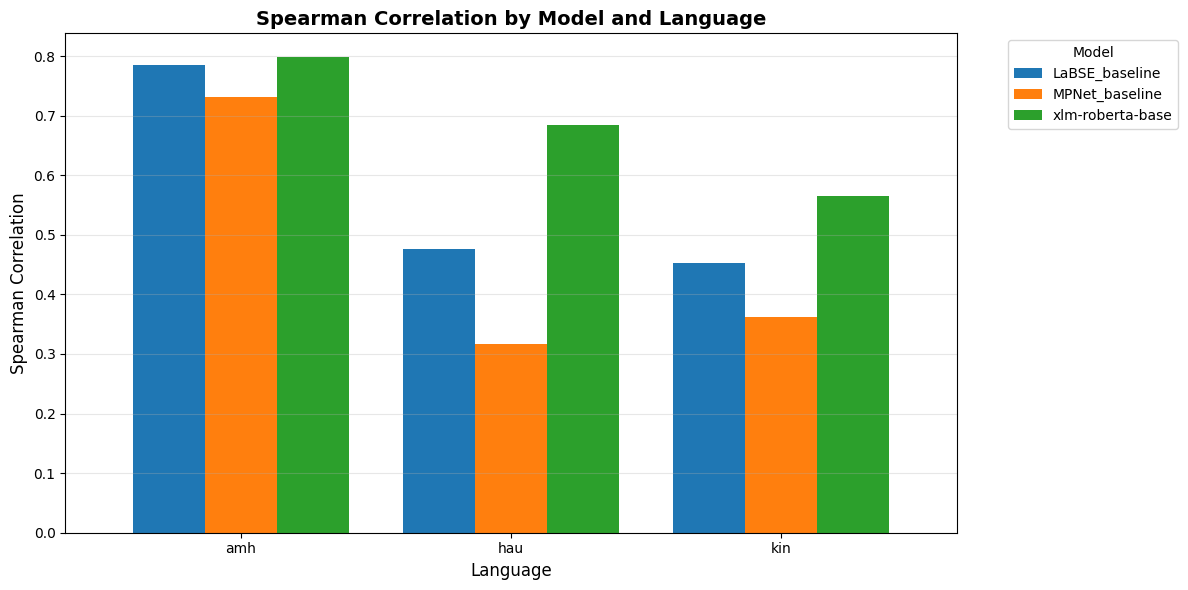

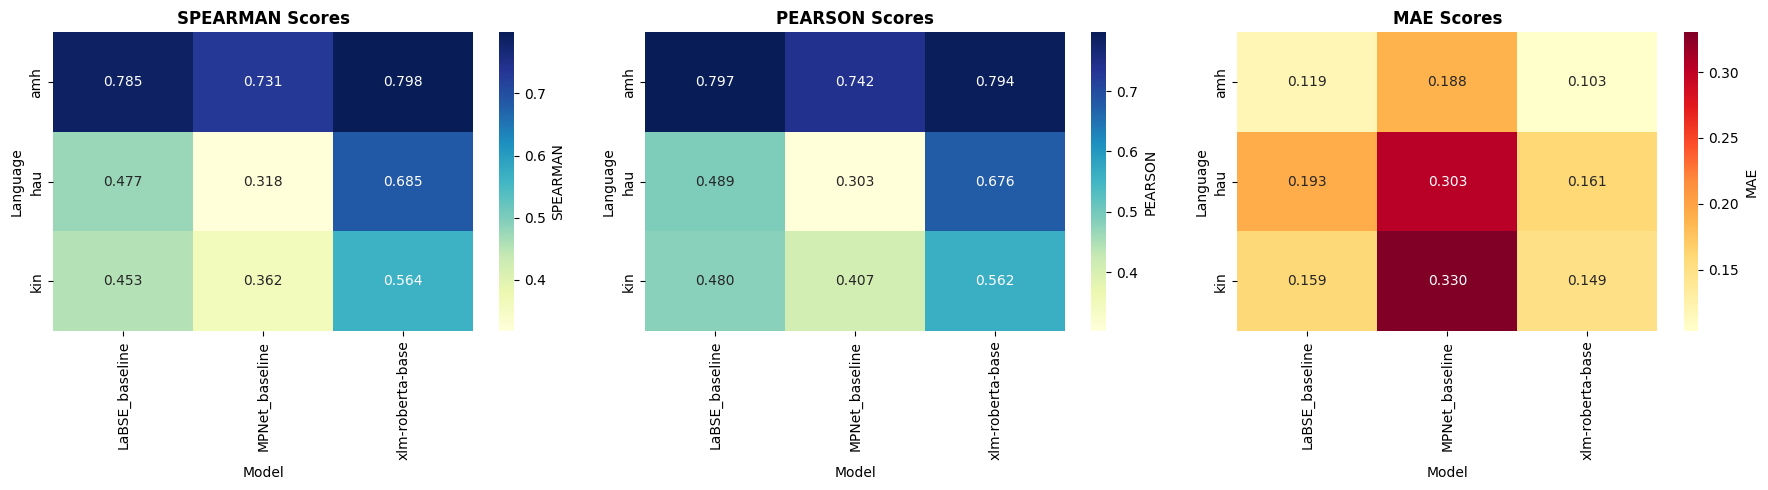

EXPERIMENT SUMMARY REPORT

[1] OVERALL BEST MODEL:
    Model: xlm-roberta-base
    Average Spearman: 0.6825

[2] BEST MODEL PER LANGUAGE:
    hau: xlm-roberta-base (0.6849)
    kin: xlm-roberta-base (0.5644)
    amh: xlm-roberta-base (0.7983)

[3] PERFORMANCE SUMMARY:
                  spearman       mae
model                               
LaBSE_baseline    0.571971  0.156984
MPNet_baseline    0.470201  0.273832
xlm-roberta-base  0.682520  0.137803


amh_LaBSE_baseline_good_prediction_rate,▁
amh_LaBSE_baseline_mean_abs_error,▁
eval/loss,█▁
eval/mae,█▁
eval/mse,█▁
eval/pearson,▁█
eval/rmse,█▁
eval/runtime,▁█
eval/samples_per_second,█▁
eval/spearman,▁█
+28,...


✓ W&B run finished

PIPELINE COMPLETE!

✓ All results saved in ./results/
✓ Performance metrics logged to Weights & Biases
✓ Error analysis and visualizations available in W&B dashboard


In [ ]:
if __name__ == "__main__":
    # Set to False if you don't have W&B configured
    USE_WANDB = True

    results = main(use_wandb=USE_WANDB)